<h1><center>CMPE 462 - Quiz 4&5 <br>Implementing a Regression Tree<br>Due: May 3, 2020, 23:59</center></h1>

# Introduction

Decision trees can learn rules to map features to both continous and discrete outputs. In this quiz, you will consider the continous case and implement a regression tree to predict house prices in Boston. You will also conduct small data analysis and evaluation procedures. This notebook will guide you through.

## (10 pts) Task 1: Dataset 

Run the cells below to load Boston house prices dataset using `scikit-learn`. You can find more detail on the dataset [here](https://scikit-learn.org/stable/datasets/index.html#boston-dataset).

When the dataset is loaded, construct train and test matrices, by allocating **first 400 samples** to train and the rest to test. ___Do not shuffle or randomly sample the feature matrix___.

In [1]:
import numpy as np
from sklearn.datasets import load_boston
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import math


In [2]:
boston = load_boston()
#print(boston)
df = pd.DataFrame(boston.data, columns=boston.feature_names)
df['target'] = boston.target

train_set = df[:400]
test_set = df[400:]
df.target.describe()
test_set.shape

(106, 14)

**(10 pts)** Unlike the dataset in Project 1, Boston dataset is high-dimensional and we cannot observe the relations between all features and the output with a single scatter plot. What we can do is to visualize the correlations between both features and house prices using a heatmap. So, stack the features and the outputs in a single matrix and compute correlation between all pairs of columns. Visualize the correlation coefficient matrix as a heatmap, which is $(N+1)x(N+1)$, where $N$ is the number of features in Boston dataset. You can check out `corrcoef` and `heatmap` functions from `numpy` and `seaborn` libraries, respectively. You can use diverging color palette to emphasize both positive and negative correlations.

Do you observe strong correlations between any pair of features or certain features and house price? 

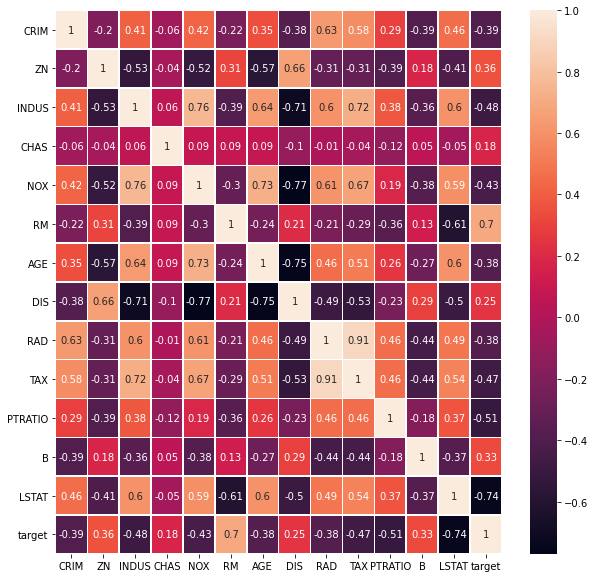

In [3]:
plt.subplots(figsize=(10,10))
corr_matrix = df.corr().round(2)
sns.heatmap(data=corr_matrix, annot=True, linewidths=.5)

12.653063241106722
6.284634387351779


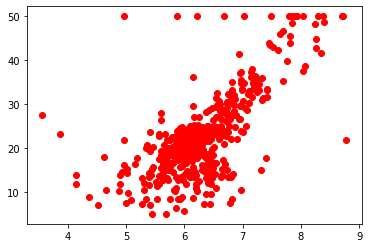

In [92]:
Lstat = df.LSTAT.to_numpy()
print(Lstat.mean())
target = df.target.to_numpy()
RM = df.RM.to_numpy()
print(RM.mean())
plt.plot(RM,target,'ro')

## (80 pts) Task 2: Regression Tree


**(15 pts)** Let us now build the regression tree. We start by implementing the splitting criteria which is used to decide the most discriminative features at each step. We stick to lecture notes and use $RSS$ which is computed as follows:

$$RSS =\sum_{\text {left }}\left(y_{i}-y_{L}^{*}\right)^{2}+\sum_{\text {right }}\left(y_{i}-y_{R}^{*}\right)^{2}$$

where $y_L^* and y_L^*$ are mean y-value of left and right nodes.

When you implement $RSS$, pick the most correlated and least correlated feature with the output prices according to previous step. Note that correlation can be both positive and negative! For both features, compute $RSS$ for every possible split threshold and plot thresholds versus RSS scores.

Do two features display different characteristics?

10.5


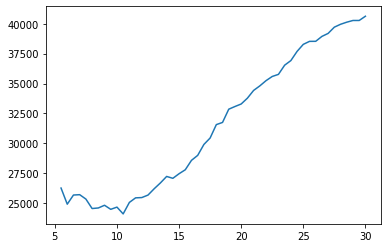

In [5]:
threshhold = 5
y = df['target'].to_numpy()
rss_list = []
thresh = [] 

def rss(yl,yr,y_left,y_right):
    rss = np.sum(np.square(yl - y_left)) + np.sum(np.square( yr - y_right))
    return rss

while threshhold < 30:
    left = df[df['LSTAT'] < threshhold]
    right = df[df['LSTAT'] > threshhold]
    y_left = left['target'].to_numpy().mean()
    y_right = right['target'].to_numpy().mean()
    yl = left['target'].to_numpy()
    yr = right['target'].to_numpy()
    rss_list.append(rss(yl ,yr, y_left,y_right))
    threshhold += 0.5
    thresh.append(threshhold)
    
plt.plot(thresh ,rss_list)
print(thresh[np.argmin(rss_list)])


#find_threshhold(df,'LSTAT')        

In [6]:
a = [1,2,3,1]
a = np.array(a)
np.square(a.mean()-3.2312313131312)
#df[df['LSTAT'] > 7]['target'].to_numpy().mean()
df["RM"].max()

8.78

6.949999999999994


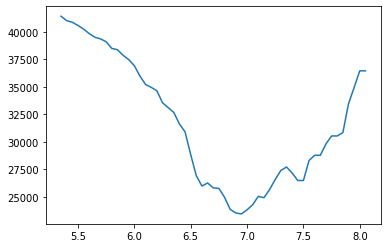

In [7]:
threshhold = 5.3
y = df['target'].to_numpy()
rss_list = []
thresh = [] 


while threshhold < 8:
    left = df[df['RM'] < threshhold]
    right = df[df['RM'] > threshhold]
    y_left = left['target'].to_numpy().mean()
    y_right = right['target'].to_numpy().mean()
    yl = left['target'].to_numpy()
    yr = right['target'].to_numpy()
    rss_list.append(rss(yl,yr,y_left,y_right))
    threshhold += 0.05
    thresh.append(threshhold)
    
plt.plot(thresh ,rss_list)
print(thresh[np.argmin(rss_list)])

#find_threshhold(df,'RM')    

In [8]:
def rss_new(yl,yr,y_left,y_right):
    rss = np.sum(np.square(yl - y_left)) + np.sum(np.square( yr - y_right))
    return rss

**(45 pts)** Now implement the training procedure of a regression tree using $RSS$ as split criteria. Build a rule tree recursively by traversing all features and considering each split threshold to find the optimum split, at every node.

You are free to implement training procedure as a standalone function or part of a class, but in any case use maximum depth as the stopping condition.

In [78]:
def find_threshhold(df,x):
    threshold = 0 
    rss_val = 9999999999
    y = df['target'].to_numpy()
    for val in df[x]:
        left = df[df[x] < val]
        right = df[df[x] > val]
        y_left = left['target'].to_numpy().mean()
        y_right = right['target'].to_numpy().mean()
        yl = left['target'].to_numpy()
        yr = right['target'].to_numpy()
        my_rss = rss_new(yl,yr,y_left,y_right)
        if(my_rss < rss_val):
            rss_val = my_rss
            threshold = val
    return threshold, rss_val

def all_thresholds(df):
    thr_byindex = []
    rss_byindex = []
    feature = []
    for i in range(13):
        x = df.columns[i]
        thr_val , rss_val = find_threshhold(df,x)
        if(thr_val != df[x].max() and thr_val != df[x].min()):
            thr_byindex.append(thr_val)
            rss_byindex.append(rss_val)
            feature.append(x)
    if(rss_byindex == []):
        return None
    ind = np.argmin(rss_byindex)
    ind2 = df.columns.get_loc(feature[ind])
    #print(ind)
    return ind2, thr_byindex[ind] 




def dec_tree(df,tree,depth = 0): # you can arrange depth on 4th if statement
    y = df['target'].to_numpy()
    if tree is None:   #1 
        return None
    elif len(df) == 0:   #2 base case no data 
        return None
    elif (y.max() - y.min()) < 5:   #3 minimum and max of y difference lower than 3
        return {'val':y.mean()}
    elif depth >= 50:   #4 : max depth reached 
        return None
    else:
        if(all_thresholds(df) is None):
            return None
        col_ind, thr = all_thresholds(df)
        #print("col" + str(col_ind) + " " + str(thr) )
        y_left = df[df[df.columns[col_ind]] < thr]  # left  data
        #print(y_left)
        y_right = df[df[df.columns[col_ind]] >= thr]  # right data
        tree = {'col': df.columns[col_ind], 'index_col':col_ind,
                    'threshold':thr,
                   'val': np.round(np.mean(df['target']))}  
        tree['left'] = dec_tree(df[df[df.columns[col_ind]] < thr], {},depth+1)   

        tree['right'] = dec_tree(df[df[df.columns[col_ind]] >= thr], {},depth+1)
        depth += 1
        return tree

    
tree = dec_tree(df,{})
print("tree created")

/home/omer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice.
  
/home/omer/.local/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/omer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice.
  if __name__ == '__main__':


tree created


In [81]:
tree

{'col': 'PTRATIO',
 'index_col': 10,
 'threshold': 20.2,
 'val': 23.0,
 'left': {'col': 'RM',
  'index_col': 5,
  'threshold': 6.939,
  'val': 26.0,
  'left': {'col': 'RM',
   'index_col': 5,
   'threshold': 6.144,
   'val': 22.0,
   'left': {'col': 'NOX',
    'index_col': 4,
    'threshold': 0.609,
    'val': 20.0,
    'left': {'col': 'RAD',
     'index_col': 8,
     'threshold': 5.0,
     'val': 20.0,
     'left': {'col': 'TAX',
      'index_col': 9,
      'threshold': 304.0,
      'val': 20.0,
      'left': {'col': 'RAD',
       'index_col': 8,
       'threshold': 3.0,
       'val': 21.0,
       'left': {'col': 'AGE',
        'index_col': 6,
        'threshold': 95.6,
        'val': 19.0,
        'left': {'val': 21.049999999999997},
        'right': {'val': 17.266666666666666}},
       'right': {'col': 'NOX',
        'index_col': 4,
        'threshold': 0.448,
        'val': 21.0,
        'left': {'val': 21.583333333333332},
        'right': {'col': 'PTRATIO',
         'index_col': 

I created tree considering all features. took feature and its threshold by looking minimum rss value among attributes. recursively done this. I chose depth as 10. maximum depth cannot be reached because compiler does not allow.

**(15 pts)** Having implemented the regression tree, now write a procedure to predict test features. Given a sample, this procedure should follow the rules learned during the training to arrive at a leaf and predict the output as the mean output of the arrived leaf samples. 

If you have implemented a regression tree class, you can insert this procedure as a class function 

In [82]:
def predict(test,tree):
    results = []
    #print(test.shape)
    for index, row in test.iterrows():    # for each row in test data

        results.append(get_prediction(row,tree))
    return results

def get_prediction(row,tree):  
    upper_tree = 0               # when you reach a None prediction in a tree return its root value
    while tree.get('threshold'):                
        #print(row)                                  
        if row[tree['index_col']] < tree['threshold']:
            
            upper_tree = tree
            tree = tree['left']
            if tree is None:
                return upper_tree.get('val')
        else:
            upper_tree = tree
            tree = tree['right']
            if tree is None:
                return upper_tree.get('val')
    else:
        
        return tree.get('val')
        

In [83]:
result = predict(test_set,tree)

In [84]:

#np.array(result, dtype = float)
result = [df.target.mean() if x is None else x for x in result]


**(5 pts)** Train your model using a max depth of 3 and visualize the resulting tree. You can use an external tool such as draw.io or LaTeX for drawing. Annotate the nodes with split columns and thresholds. You can view the tree in this [link](https://scikit-learn.org/stable/modules/tree.html#tree) as an example. 

## **(10 pts)** Task 3: Evaluation

**(5 pts)** Now is time to pick the best maximum depth and observe your tree's performance! Implement a 5-fold cross validation procedure to experiment with maximum depths from 3 to 10. Report mean and standard deviation for each depth and pick the best one. For comparison you can use $R^2$, which is a metric frequently used to evaluate regression models. You can use `r2_score` function of `scikit-learn` and read more [here](https://scikit-learn.org/stable/modules/model_evaluation.html#r2-score).

In [85]:
y_true = test_set['target'].to_numpy()
y_pred = result
r2_score(y_pred,y_true)

0.8895278082428739

In [88]:
#df.target.mean()

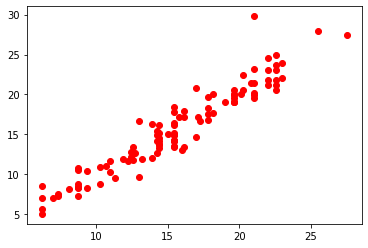

In [89]:
plt.plot(y_pred, y_true,'ro')

**(5 pts)** To conclude, train your tree one last time on the whole training data with the depth you picked in the previous section. Generate predictions on both training and test sets and report $R^2$ scores.

In [91]:
result = predict(train_set,tree)
y_true = train_set['target'].to_numpy()
y_pred = result
r2_score(y_pred,y_true)

0.9709625671802431